# Compute and plot tide from OTPS2 (TPXO8) fortran code

In [1]:
%matplotlib notebook

In [101]:
import numpy as np
import datetime
import pandas
import urllib2, urllib
import pytides
import os
import subprocess
import copy
from netCDF4 import Dataset


In [3]:
#define point of measurement

In [4]:
point=1870

In [5]:
#start date
tstamp='20160601.000'
tin=datetime.datetime.strptime(tstamp,"%Y%m%d.%H%M%S")

In [6]:
#end day
estamp='20160630.000'
ed=datetime.datetime.strptime(estamp,"%Y%m%d.%H%M%S")

## READ tide gauge measurements

In [7]:
url='http://webcritech.jrc.ec.europa.eu/SeaLevelsDb/Home/ShowBuoyData?id={}&dateMin={}%2F{:02d}%2F{:02d}+{:02d}%3A{:02d}&dateMax={}%2F{:02d}%2F{:02d}+{:02d}%3A{:02d}&field=&options='\
                                 .format(point,tin.year,tin.month,tin.day,tin.hour,0,ed.year,ed.month,ed.day,ed.hour,0)


In [8]:
response=urllib2.urlopen(url)
ls=response.readlines()
lp=[elem.strip().split(',')  for elem in ls]

# get lat lon
c=[a.split(' ') for a in lp[1]][0]
if 'lat' in c[2]: 
           plat=c[2].split('=')[1]
           idt=6
else:
           c=[a.split(' ') for a in lp[2]][0]
           if 'lat' in c[2]: plat=c[2].split('=')[1]
           idt=7

if 'lon' in c[3]: plon=c[3].split('=')[1]



In [9]:
print plon, plat

12.427 45.418


In [10]:
rt=[]
vt=[]
for a,b,c,d in lp[idt:]:
    rt.append(datetime.datetime.strptime(a,'%d %b %Y %H:%M:%S'))
    vt.append(c) # tide column

In [11]:
d=np.array([rt,vt]).T

In [12]:
dat1=pandas.DataFrame(d,columns=['time','elev'])

In [13]:
dat1=dat1.set_index(['time'])

In [14]:
dat1['elev']=pandas.to_numeric(dat1['elev']) # convert string to floats

In [15]:
ax1=dat1.plot(figsize=(12,4))
ax1.set_ylabel('h')

<IPython.core.display.Javascript object>

## Compute constituents from measurements

In [16]:
demeaned=dat1['elev'].values-dat1['elev'].values.mean()

In [17]:
tide=pytides.tide.Tide.decompose(demeaned, dat1['elev'].index)

In [18]:
constituent = [c.name for c in tide.model['constituent']]

In [19]:
df=pandas.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)

In [20]:
df

,amplitude,phase
Z0,1.109183e-17,0.000000
M2,1.183897e-01,7.178870
S2,1.137295e+01,355.621837
N2,8.966808e-01,235.440886
K1,9.400331e+00,205.824188
M4,2.513641e-03,268.620406
O1,1.084882e-01,356.504643
M6,4.237383e-04,51.799441
MK3,3.900117e-03,0.417406
S4,1.408288e-03,159.123467


In [21]:
#df.sort_values(by='amplitude', ascending=False).head(10)

In [22]:
tide.model['phase']


array([   0.        ,    7.17887009,  355.62183657,  235.44088556,
        205.8241881 ,  268.62040643,  356.50464252,   51.79944148,
          0.41740598,  159.12346655,  241.59781104,  158.57531716,
        208.91007232,  334.85031141,   52.19345749,  246.87450711,
        135.9662969 ,   34.33863314,   10.17435131,  192.7834203 ,
         13.32871393,   71.38233486,  145.62220869,    0.36299646,
        189.01905662,  155.87317226,  219.75288528,  236.78204627,
        184.66776028,   51.69540758,  259.56024412,  235.67360696,
        282.35410497,  252.98320061])

### validating tide analysis

In [23]:
dates=pandas.date_range(start='2016-06-01',end='2016-06-30',freq='6T')

In [24]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [26]:
times=pytides.tide.Tide._times(dates[0], hours)

In [27]:
validation = pandas.Series(tide.at(times) + dat1['elev'].values.mean(), index=dates)

<IPython.core.display.Javascript object>


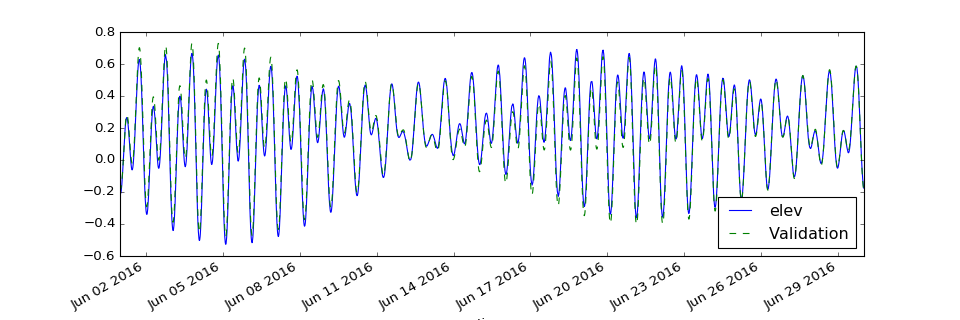

In [28]:
ax = dat1.plot(figsize=(12,4), label='Observed data')
ax = validation.plot(ax=ax, color='green', linestyle='--', label='Validation')
leg=ax.legend(loc='best')

### Predicting tide 

In [29]:
dates=pandas.date_range(start='2016-06-30',end='2016-07-30',freq='6T')

In [30]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [32]:
times=pytides.tide.Tide._times(dates[0], hours)

In [33]:
prediction = pandas.Series(tide.at(times) + dat1['elev'].values.mean(), index=dates)

<IPython.core.display.Javascript object>


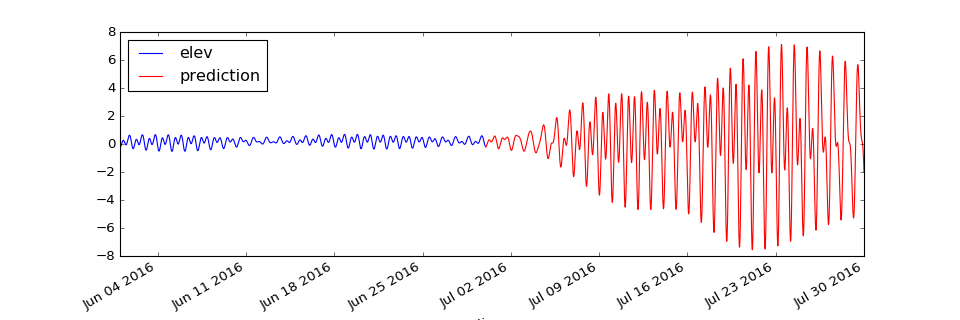

In [34]:
ax = dat1.plot(figsize=(12,4), label='Observed data')
ax = prediction.plot(ax=ax, color='red', label='prediction')
leg=ax.legend(loc='best')

### Setup the fortan files

In [35]:
path='../TIDES/OTPS2/'

In [36]:
# location
#plon=-5.72
#plat=36.

In [37]:
#dt
delta=datetime.timedelta(hours=1)

In [38]:
with open(path+'lat_lon_time1','w') as f:
    while tin <= ed: 
     f.write('{}  {}  {}  {}  {}  {}  {}  {}\n'.format(plat,plon,tin.year,tin.month,tin.day,tin.hour,tin.minute, tin.second))
     tin += delta

## Evaluate Constituents (TPX08)

In [39]:
ex=subprocess.Popen('./extract_HC < setup.inp', cwd=path, shell=True, stdout=subprocess.PIPE)
stdout=ex.communicate()[0]
print stdout

 DATA/Model_atlas_v1
 Lat/Lon file:lat_lon_time1
 Extract OCEAN tide HC
 Model type: atlas (combined of several models)
 Models in atlas:          30
 Lat limits:     -90.0833359       90.0833359    
 Lon limits:      8.33384171E-02   360.083344    
 Output elevations (m)
 Constituents: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Constituents to include: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Loading local solution grid Med2011             
 Loading local solution elevations Med2011             
 Results are in sample1.out



In [40]:
out=pandas.read_csv(path+'sample1.out',skiprows=[0,1,3],delim_whitespace=True, skipinitialspace=True)#, index_col=['mm.dd.yyyy','hh:mm:ss'] )

In [41]:
out

,Lat,Lon,m2_amp,m2_ph,s2_amp,s2_ph,n2_amp,n2_ph,k2_amp,k2_ph,...,m4_amp,m4_ph,ms4_amp,ms4_ph,mn4_amp,mn4_ph,mm_amp,mm_ph,mf_amp,mf_ph
0,45.418,12.427,0.236,-98.8,0.152,-96.2,0.032,-93.7,0.036,-92.2,...,0.001,107.4,0.001,-149.5,0.001,166.2,0.004,-165.6,0.007,-172.9


In [42]:
cst=out.drop(['Lat','Lon'], axis=1).T

In [43]:
idx=[ c.split('_')[0] for c in cst.index[::2]]

In [44]:
for i in range(np.size(idx)):
    if idx[i] != 'mf' : 
        idx[i]=idx[i][:].upper()
    else:
        idx[i]=idx[i][:1].upper()+idx[i][1:]

In [45]:
pcst=pandas.DataFrame(cst.values.reshape((-1,2)), columns=['amplitude','phase'], index=idx)

In [46]:
#compare the 2 solutions
com=pandas.concat([pcst,df], axis=1).dropna()

In [47]:
com

,amplitude,phase,amplitude,phase
K1,0.145,60.6,9.400331,205.824188
K2,0.036,-92.2,2.641452,235.673607
M2,0.236,-98.8,0.118390,7.178870
M4,0.001,107.4,0.002514,268.620406
MN4,0.001,166.2,0.001694,241.597811
MS4,0.001,-149.5,0.001235,252.983201
Mf,0.007,-172.9,0.010371,13.328714
N2,0.032,-93.7,0.896681,235.440886
O1,0.033,61.9,0.108488,356.504643
P1,0.044,62.2,9.027076,219.752885


## Predict tide (TPX08)

In [48]:
tp=subprocess.Popen('./predict_tide < setup.inp', cwd=path, shell=True, stdout=subprocess.PIPE )
stdout=tp.communicate()[0]
print stdout

 DATA/Model_atlas_v1
 Lat/Lon/Time file:lat_lon_time1
 Predict OCEAN tide
 Interpolate minor constituents
 Model type: atlas (combined of several models)
 Models in atlas:          30
 Lat limits:     -90.0833359       90.0833359    
 Lon limits:      8.33384171E-02   360.083344    
 Predict elevations (m)
 Constituents: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Constituents to include: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Loading local solution grid Med2011
 Loading local solution elevations Med2011             
 Results are in sample1.out



In [49]:
data=pandas.read_csv(path+'sample1.out',skiprows=[0,1,2,3,6],delim_whitespace=True, skipinitialspace=True)#, index_col=['mm.dd.yyyy','hh:mm:ss'] )

In [50]:
#print first row for verification
data[:1]

,Lat,Lon,mm.dd.yyyy,hh:mm:ss,z(m),Depth(m)
0,45.418,12.427,06.01.2016,00:00:00,-0.342,5


In [51]:
#merge columns for date
data['time']=data['mm.dd.yyyy'].astype(str).str.cat(data['hh:mm:ss'].astype(str), sep=' ')

In [52]:
#print first row for verification
data[:1]

,Lat,Lon,mm.dd.yyyy,hh:mm:ss,z(m),Depth(m),time
0,45.418,12.427,06.01.2016,00:00:00,-0.342,5,06.01.2016 00:00:00


In [53]:
#Delete unwanted columns
dat = data.drop(['Lat','Lon','Depth(m)','mm.dd.yyyy', 'hh:mm:ss'], axis=1)

In [54]:
dat['time']=pandas.to_datetime(dat['time'])

In [55]:
#set time as index
dat=dat.set_index(['time'])

In [56]:
#h=pandas.Series(dat['z(m)'])

<IPython.core.display.Javascript object>


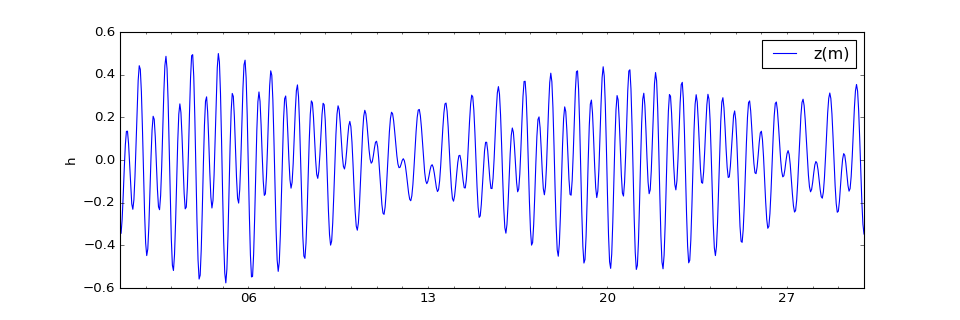

In [57]:
ax=dat.plot(figsize=(12,4))
ax.set_ylabel('h')


In [58]:
#put together
#add2=dat1.join(dat,how='inner')

In [59]:
#add2.plot(x=add2.index,y=['elev','z(m)'], figsize=(12,4))

In [60]:
# Add the mean value of the measurement
dat['z(m)']=dat['z(m)']+dat1['elev'].values.mean()

<IPython.core.display.Javascript object>


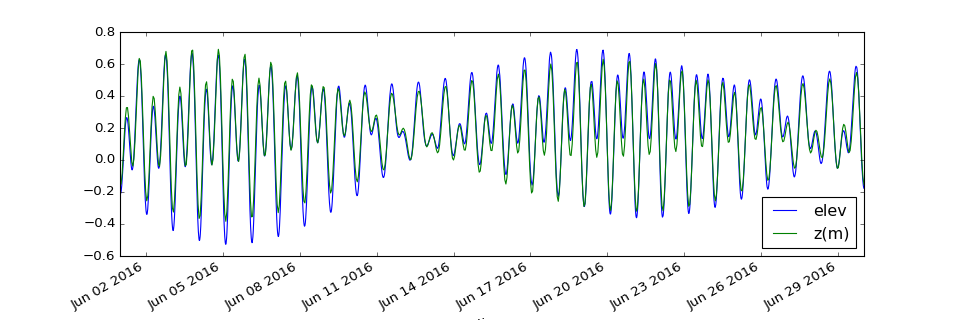

In [62]:
# PLOT TOGETHER
ax3=dat1.plot(figsize=(12,4))
dat.plot(ax=ax3)

In [63]:
# set a tide object to validate
to=copy.deepcopy(tide)

In [64]:
to.model['amplitude']

array([  1.10918317e-17,   1.18389746e-01,   1.13729484e+01,
         8.96680797e-01,   9.40033111e+00,   2.51364147e-03,
         1.08488218e-01,   4.23738287e-04,   3.90011723e-03,
         1.40828771e-03,   1.69350333e-03,   9.12895711e-01,
         3.09261129e-04,   2.63573581e-01,   1.95540113e-01,
         3.82051842e-02,   2.03693077e+00,   1.73635457e+01,
         1.13620613e-01,   6.21422134e-02,   1.03705422e-02,
         2.32553380e-01,   2.29615139e-01,   6.88269064e+00,
         6.53016077e+00,   1.05582932e-02,   9.02707649e+00,
         2.30288020e-03,   6.06938359e-03,   2.42379258e+00,
         4.24987123e-03,   2.64145155e+00,   1.61672896e-03,
         1.23510823e-03])

In [65]:
k=0
for c,a,p in to.model:
    if c.name in pcst.index:
        to.model['amplitude'][k] = pcst['amplitude'][c.name]
        to.model['phase'][k] = pcst['phase'][c.name]
    else:
        to.model['amplitude'][k]=0.
        to.model['phase'][k]=0.
    k +=1    

In [66]:
to.model['amplitude']

array([ 0.   ,  0.236,  0.152,  0.032,  0.145,  0.001,  0.033,  0.   ,
        0.   ,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.007,  0.   ,  0.007,  0.   ,
        0.   ,  0.   ,  0.044,  0.   ,  0.   ,  0.   ,  0.   ,  0.036,
        0.   ,  0.001])

#### computing tide

In [67]:
dates=pandas.date_range(start='2016-06-01',end='2016-06-30',freq='6T')

In [68]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [71]:
times=pytides.tide.Tide._times(dates[0], hours)

In [72]:
tpx08 = pandas.Series(to.at(times) + dat1['elev'].values.mean(), index=dates)

<IPython.core.display.Javascript object>


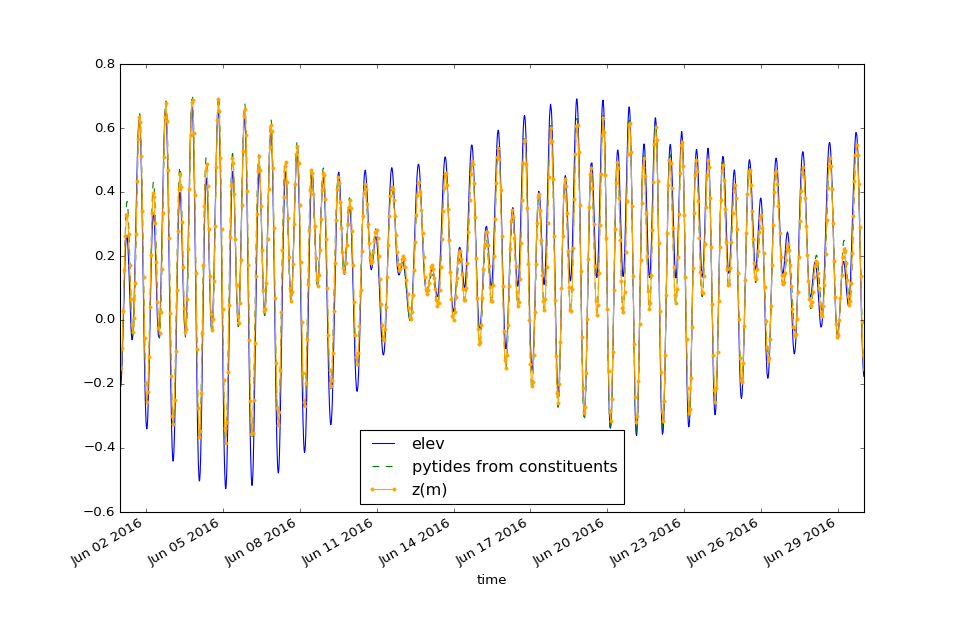

In [100]:
ax = dat1.plot(figsize=(12,8), label='Observed data')
tpx08.plot(ax=ax, color='green', linestyle='--', label='pytides from constituents')
#validation.plot(ax=ax, color='k', linestyle='--', label='pytides from Observed Data')
dat.plot(ax=ax, color='orange', linestyle='-', marker='.', label='tpx08 prediction')
leg=ax.legend(loc='best')

## Get the values from DELTARES med.nc

In [102]:
dmed=Dataset(path+'../med.nc')

In [104]:
dmed.variables.keys()

[u'crs',
 u'lon',
 u'lat',
 u'lon_u',
 u'lat_u',
 u'lon_v',
 u'lat_v',
 u'tidal_constituents',
 u'tidal_amplitude_h',
 u'tidal_phase_h',
 u'tidal_amplitude_u',
 u'tidal_phase_u',
 u'tidal_amplitude_v',
 u'tidal_phase_v',
 u'tidal_amplitude_U',
 u'tidal_phase_U',
 u'tidal_amplitude_V',
 u'tidal_phase_V',
 u'depth']